# Import packages

In [1]:
import os
import re
import unicodedata
# %pip install spacy --quiet
import spacy
# %pip install pandas --quiet
import pandas as pd
# %pip install matplotlib --quiet
import matplotlib.pyplot as plt
# %pip install python-dotenv --quiet
from dotenv import load_dotenv
# %pip install sklearn --quiet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
# %pip install nltk --quiet
import nltk
from nltk.stem import WordNetLemmatizer
# !python -m spacy download en_core_web_sm

c:\Users\Misch\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# Load the environment variables
load_dotenv()

# Get the directory of the datasets
data_dir = os.getenv("DATA_DIR")

# Get the directory of the articles
articles_dir = os.path.join(data_dir, "articles")

In [3]:
# Load the main dataset
df = pd.read_csv(f"{data_dir}/article_info_V2.csv", index_col=0, parse_dates=[1])

# Load the external dataset
external_df = pd.read_csv(f"{data_dir}/other-articles.csv", index_col=0, parse_dates=[1], sep=";")

# Load the custom categories dataset
custom_categories = pd.read_csv(f"{data_dir}/new-categories.csv")

In [4]:
# Load the English spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the stopwords from spacy
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load NLTK punkt package
nltk.download("punkt")

# Load NLTK wordnet package
nltk.download("wordnet")

# Load NLTK omw package
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Misch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Misch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Misch\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10194 entries, 0 to 10193
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Date      10193 non-null  datetime64[ns, UTC]
 1   Type      10194 non-null  object             
 2   Title     10194 non-null  object             
 3   Tags      10194 non-null  object             
 4   Keywords  10194 non-null  object             
 5   Author    10194 non-null  object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 557.5+ KB


# Merge preparation

In [6]:
# Drop unused columns
df.drop(columns=["Author", "Type", "Keywords"], inplace=True)

# Reset the index of the dataframe
df.reset_index(drop=True, inplace=True)

# Remove the url column from the external dataset
external_df.drop(columns=["Url"], inplace=True)

# Merge external dataset

In [7]:
# Add the external dataset to the main dataset
df = pd.concat([df, external_df])

# Reset the index of the dataframe
df.reset_index(drop=True, inplace=True)

# Delete the external dataset variable
del external_df

# Cleaning

In [8]:
# Remove duplicate entries by title and date
df.drop_duplicates(subset=["Title", "Date"], keep="first", inplace=True)

# Drop the date column
df.drop(columns=["Date"], inplace=True)

# After receiving feedback from SKC, we decided to drop the following categories:
custom_categories.drop(columns=["People", "Places", "Criminal groups"], inplace=True)

# Load the contents of articles

In [9]:
# Article loading function
def load_article(title):
    # Create filename from title
    file_name = f"{title}.txt"
    # Get the path of the article
    file_path = os.path.join(articles_dir, file_name)
    try:
        # Attempt to read the article
        file = open(file_path, "r", encoding="utf-8")
    except:
        # If the article could not be read, return None
        return None
    # Read the contents of the article
    contents = file.read()
    # Close the file
    file.close()
    # Return the contents of the article
    return contents

# Load the articles
df["Contents"] = df["Title"].apply(load_article)

# Delete the article loading function
del load_article

# Remove articles which cannot be found

In [10]:
# Remove rows without article contents
df.dropna(subset=["Contents"], inplace=True)

# Reset the index of the dataframe
df.reset_index(drop=True, inplace=True)

# Parse the old target

In [11]:
# Define functions to parse target
def clean_string(str):
    # Make the string lowercase
    str = str.lower()
    # Remove all non-alphanumeric characters
    str = re.sub(r"[^\w\s]", "", str)
    # Remove the leading and trailing spaces
    return str.strip()

def parse_tags(str):
    # Split the string on each comma
    raw_list = str.split(",")
    # Clean every string in the list
    return list(map(clean_string, raw_list))


def get_unique_values(list_of_lists):
    # Get a list of unique tags from a list of lists
    unique_values = list(set([value for value_list in list_of_lists for value in value_list]))
    # Filter out any values that are empty
    unique_values = [tag for tag in unique_values if tag]
    # Return the unique values
    return unique_values

# Convert the raw string values of the Tags column to lists of strings
df["Tags"] = df["Tags"].apply(parse_tags)

# Get all the unique tags from the Tags column
unique_tags = get_unique_values(df["Tags"])

# Create a list of words which should not occur in the tags
forbidden_words = ["COVERAGE", "SEE", "INSIGHT CRIME", "SOURCES", "THE", "LINKED", "MEDIA", "CREATED", "HOTSPOT", "CARGO", "MORE"]

# Remove any tag that contains forbidden words
unique_tags = [tag for tag in unique_tags if not any(word in tag for word in forbidden_words)]

# Remove any tag that contains less than 3 characters
unique_tags = [tag for tag in unique_tags if len(tag) > 3]

# Remove any tag that contains more than 3 words
unique_tags = [tag for tag in unique_tags if len(tag.split()) <= 3]

print(unique_tags)

# Delete the variables that are no longer needed
del clean_string, parse_tags, forbidden_words, get_unique_values

['brazil militias', 'ecuador news', 'criminal migration', 'see also', 'honeymoon', 'gang', 'chepe diablo', 'violence', 'hector beltran leyva', 'uruguay', 'otoniel', 'security policy', 'perú', 'asec', 'paraguay groups', 'gulf cartel', 'farc', 'illegal mining', 'colombia personalities', 'continue', 'invisibles', 'methamphetamine', 'trafficking in wildlife', 'bagdad', 'honduras', 'coverage of ms13', 'the truce', 'coverage of pcc', 'colombia', 'farc peace process', 'illegal mining coverage', 'profitable', 'coverage of microtrafficking', 'el ingeniero tijuana', 'alex saab', 'contrabando', 'antonio garcia', 'coverage of panama', 'sources say', 'tauted', 'mexico personalities', 'dominican republic', 'soccer crime', 'libertadores del vichada', 'cocaine traffickers', 'extorti', 'coverage of counterfeiting', 'growing influence', 'the infiltrators', 'pinr', 'el paisa', 'prel', 'el koki', 'el salvador seguro', 'money laundering', 'bacrim', 'coverage of displacement', 'coverage of infographics', 'c

# (Temporary) Validate all the remaining tags using the InSight Crime website

In [12]:
# import requests

# # Make all unique tags lowercase
# unique_tags = [tag.lower() for tag in unique_tags]
# # Replace all non-ascii characters with ascii equivalents
# unique_tags = [unicodedata.normalize("NFKD", tag).encode("ascii", "ignore").decode("ascii") for tag in unique_tags]
# # Join the words in every unique tag together with dashes
# unique_tags = ["-".join(tag.split()) for tag in unique_tags]
# # Create a url using the unique tags and https://insightcrime.org/tag/ as the prefix
# urls = ["https://insightcrime.org/tag/" + tag for tag in unique_tags]
# # Send a GET request to each of the urls
# for url in urls:
#     # Send a GET request to the tag
#     response = requests.get(url)
#     # Print the current tag and response code to the console
#     print(f"{url} - {response.status_code}")
#     # If the response is 404, then remove the tag from the list
#     if response.status_code == 404:
#         # Remove the prefix from the url
#         tag = url.replace("https://insightcrime.org/tag/", "")
#         # Remove the unique tag
#         unique_tags.remove(tag)

# # Advice: Replace tags that are similar by the valid tag - e.g. paraguay news, paraguay -> paraguay

# Create the new target

In [13]:
def increment_counters(counters, category_name):
    # Check if the category is in the counters dictionary
    if category_name not in counters:
        # If the category does not exist in the counters, create it
        counters[category_name] = 1
    else:
        # If the category exists in the counters, increment the counter
        counters[category_name] += 1

def iterate_categories(counters, tag):
    # Iterate over the categories
    for category_name in categories:
        # Get the current category
        category = categories[category_name]
        # Check if the tag is in the category list
        if tag in category:
            # Increment the counter of the category
            increment_counters(counters, category_name)

# Define a function to parse the custom categories into a list of strings
def load_category(name):
    try:
        # Load the category as a list while removing empty values
        return custom_categories[name].dropna().tolist()
    except:
        return None

# Initiate the category dictionary
categories = {}

# Iterate over these custom_categories columns
for category_name in custom_categories.columns:
    # Load the category
    categories[category_name] = load_category(category_name)

# Create a new column for the category
df["Category"] = ""

# Iterate over the dataframe to create the category for each article
for index, row in df.iterrows():
    # Get the tags of the current row
    tag_list = row["Tags"]

    # Create a dictionary for the counters of the categories for this article
    counters = {}

    # Iterate over every tag in the tag list
    for tag in tag_list:
        iterate_categories(counters, tag)

    # Check if any category was found for this article
    if len(counters) == 0:
        # If no matching category was found, assign the default category to the row
        row["Category"] = "Other"
    else:
        # Get the category with the highest counter and assign it to the row
        row["Category"] = max(counters, key=counters.get)

# Delete the variables that are no longer needed
del load_category

# Drop the old target column

In [14]:
# Removes the tags column from the dataframe
df.drop(columns=["Tags"], inplace=True)

# Remove articles with the "Other" (default) category

In [15]:
# Drop rows with the other category
df.drop(df[df["Category"] == "Other"].index, inplace=True)

# Visualizations

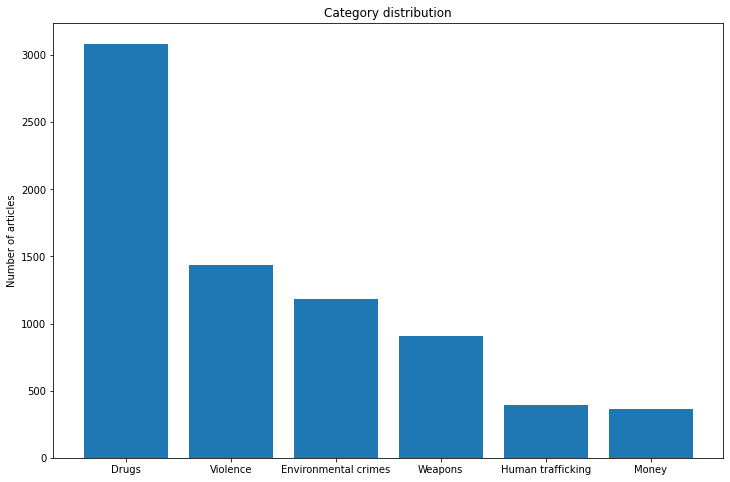

In [16]:
category_counts = df["Category"].value_counts()
plt.figure(figsize=(12, 8))
plt.title("Category distribution")
plt.ylabel("Number of articles")
plt.bar(category_counts.index, category_counts.values)
plt.show()

# Prepare input data

In [17]:
lemmatizer = WordNetLemmatizer()

# Lemmatize the words in sentences
def lemmatize_sentences(sentences):
    # Create a new list of lemmatized sentences
    cleaned_sentences = []
    # Iterate over every sentence
    for sentence in sentences:
        # Convert the sentence tokens
        words = nltk.word_tokenize(sentence)
        # Remove digits from the words
        words = [word for word in words if not word.isdigit()]
        # Remove stopwords from the words
        words = [word for word in words if word not in stop_words]
        # Lemmatize the words
        words = [lemmatizer.lemmatize(word) for word in words]
        # Remove words with less than 4 characters
        words = [word for word in words if len(word) > 3]
        # Check if the number of words is greater than 0
        if len(words) > 0:
            # Add the words to the list of cleaned sentences
            cleaned_sentences.append(words)
    # Return the cleaned sentences
    return cleaned_sentences

def text_to_sentences(text):
    # Make text lowercase
    text = text.lower()
    # Replace non ascii characters with their ascii counterpart
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    # Remove digits from the text
    text = re.sub(r"\d+", "", text)
    # Remove words with non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Remove double whitespace
    text = re.sub(r"\s+", " ", text)
    # Split the text into sentences
    sentences = nltk.sent_tokenize(text)
    # Lemmatize the sentences
    sentences = lemmatize_sentences(sentences)
    # Remove empty sentences
    sentences = list(filter(None, sentences))
    # Join the words in sentences together as a string
    sentences = list(map(lambda x: " ".join(x), sentences))
    # Return the list of sentences
    return sentences

# Create a new column for the sentences of the articles
df["Sentences"] = df["Contents"].apply(text_to_sentences)

# Delete variables that are no longer needed
del lemmatizer

# Convert input data to a TfidfVector

In [18]:
# Check if a column/word occurs in at least 20 articles and in max 50% of the articles
def check_column(column):
    count = column.value_counts()[column.value_counts() > 0].count()
    return count >= 20 and count / len(column) < 0.5

# Create a vocabulary of words from the sentences
documents = df["Sentences"].apply(lambda x: " ".join(x)).tolist()

# Create a new TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Create a TFIDF matrix from the sentences
values = tfidf_vectorizer.fit_transform(documents)

# Get the column names of the TFIDF matrix
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a new dataframe from the TFIDF matrix
vector_df = pd.DataFrame(values.toarray(), columns=feature_names)

# Get columns that do not match the criteria of the check_column function
columns_to_drop = list(filter(lambda x: not check_column(vector_df[x]), vector_df.columns))

# Remove all columns that did not match the criteria
vector_df.drop(columns=columns_to_drop, inplace=True)

# Modelling

In [19]:
# Some functions to display metrics of a model's performance
def specificity_score(target, predictions):
    return 1 - recall_score(target, predictions, average="weighted")

def get_metrics(target, predictions):
    return {
        "recall": recall_score(target, predictions, average="weighted"),
        "precision": precision_score(target, predictions, average="weighted"),
        "accuracy": accuracy_score(target, predictions),
        "specificity": specificity_score(target, predictions),
        "f1": f1_score(target, predictions, average="weighted"),
    }

def print_metrics(target, predictions):
    metrics = get_metrics(target=target, predictions=predictions)
    for metric in metrics:
        str_metric = "{:.2f}".format(metrics[metric] * 100)+"%"
        print(f"{metric}: {str_metric}")

# Split train and test data

In [20]:
# Get input data
X = vector_df
# Get target data
y = pd.get_dummies(df["Category"])

# Split the data into training, testing and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# Decision Tree Classifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier model
dtc = DecisionTreeClassifier(max_depth=50, random_state=42)

# Fit and train the model
dtc = dtc.fit(X_train, y_train)

In [36]:
# Predict the test data
y_pred_dtc = dtc.predict(X_test)

# Predict the training data
y_pred_dtc_train = dtc.predict(X_train)

# Predict the validation data
y_pred_dtc_val = dtc.predict(X_val)

# Print the metrics of the test data
print("Test data:")
print_metrics(y_test, y_pred_dtc)

# Print the metrics of the training data
print("\nTrain data:")
print_metrics(y_train, y_pred_dtc_train)

# Print the metrics of the validation data
print("\nValidation data:")
print_metrics(y_val, y_pred_dtc_val)

Test data:
recall: 36.93%
precision: 36.95%
accuracy: 36.93%
specificity: 63.07%
f1: 36.88%

Train data:
recall: 99.84%
precision: 100.00%
accuracy: 99.84%
specificity: 0.16%
f1: 99.92%

Validation data:
recall: 38.25%
precision: 38.02%
accuracy: 38.25%
specificity: 61.75%
f1: 38.07%


# Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create a DecisionTreeClassifier model
rfc = RandomForestClassifier()

# Fit and train the model
rfc = rfc.fit(X_train,y_train)

In [37]:
# Predict the test data
y_pred_rfc = rfc.predict(X_test)

# Predict the training data
y_pred_rfc_train = rfc.predict(X_train)

# Predict the validation data
y_pred_rfc_val = rfc.predict(X_val)

# Print the metrics of the test data
print("Test data:")
print_metrics(y_test, y_pred_rfc)

# Print the metrics of the training data
print("\nTrain data:")
print_metrics(y_train, y_pred_rfc_train)

# Print the metrics of the validation data
print("\nValidation data:")
print_metrics(y_val, y_pred_rfc_val)

Test data:
recall: 22.95%
precision: 64.50%
accuracy: 22.95%
specificity: 77.05%
f1: 29.76%

Train data:
recall: 99.82%
precision: 100.00%
accuracy: 99.82%
specificity: 0.18%
f1: 99.91%

Validation data:
recall: 24.73%
precision: 64.24%
accuracy: 24.73%
specificity: 75.27%
f1: 31.08%


c:\Users\Misch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Misch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# K-Neighbors Classifier

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNeighborsClassifier model
knn = KNeighborsClassifier()

# Fit and train the model
knn = knn.fit(X_train,y_train)

In [38]:
# Predict the test data
y_pred_knn = knn.predict(X_test)

# Predict the training data
y_pred_knn_train = knn.predict(X_train)

# Predict the validation data
y_pred_knn_val = knn.predict(X_val)

# Print the metrics of the test data
print("Test data:")
print_metrics(y_test, y_pred_knn)

# Print the metrics of the training data
print("\nTrain data:")
print_metrics(y_train, y_pred_knn_train)

# Print the metrics of the validation data
print("\nValidation data:")
print_metrics(y_val, y_pred_knn_val)

Test data:
recall: 19.42%
precision: 52.14%
accuracy: 19.42%
specificity: 80.58%
f1: 23.62%

Train data:
recall: 34.19%
precision: 78.52%
accuracy: 34.19%
specificity: 65.81%
f1: 41.18%

Validation data:
recall: 21.13%
precision: 55.54%
accuracy: 21.13%
specificity: 78.87%
f1: 26.10%


c:\Users\Misch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


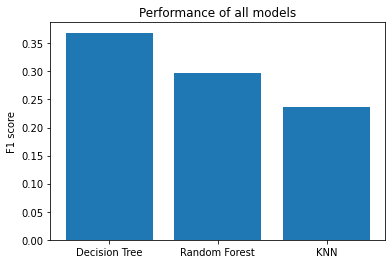

In [41]:
dtc_metrics = get_metrics(y_test, y_pred_dtc)
rfc_metrics = get_metrics(y_test, y_pred_rfc)
knn_metrics = get_metrics(y_test, y_pred_knn)
# Show all metrics in a bar chart
plt.title("Performance of the models")
plt.ylabel("F1 score")
plt.bar(["Decision Tree", "Random Forest", "KNN"], [dtc_metrics["f1"], rfc_metrics["f1"], knn_metrics["f1"]])
plt.show()

In [27]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

# Create a new column called Keywords
df["Keywords"] = ""

# Write multiple patterns to find if an article contains cocaine etc.
pattern = [
# Drugs
[{"LEMMA": "drug"},{"POS": "NOUN", "OP": "?"}],
[{"POS": "ADJ", "OP": "?"},{"TEXT": "cocaine"},{"POS": "NOUN", "OP": "?"}],
# Environmental crimes
[{"LEMMA": "deforestation"}],
[{"LEMMA": "environment"}],
[{"LEMMA": "illegal"},{"POS": "NOUN", "OP": "?"}],
# Violence
[{"LEMMA": "violence"}],
[{"TEXT": "violent"},{"POS": "NOUN", "OP": "?"}],
[{"LEMMA": "kidnap"}],
[{"POS": "NOUN", "OP": "?"},{"LEMMA": "threat"}],
[{"LEMMA": "murder"}],
[{"LEMMA": "shoot"}],
[{"TEXT": "death"}],
[{"TEXT": "assassin"}],
[{"LEMMA": "robbery"}],
[{"TEXT": "hitman"}],
[{"TEXT": "dead"}],
[{"TEXT": "execution"}],
[{"POS": "NOUN", "OP": "?"},{"LEMMA": "killing"}],
# Weapons
[{"POS": "ADJ", "OP": "?"},{"LEMMA": "weapon"},{"POS": "NOUN", "OP": "?"}],
[{"POS": "VERB", "OP": "?"},{"LEMMA": "weapon"}],
[{"LEMMA": "arms"},{"POS": "NOUN", "OP": "?"}],
[{"LEMMA": "gun"},{"POS": "NOUN", "OP": "?"}],
[{"TEXT": "AK-47"}],
[{"LEMMA": "explosive"}],
[{"POS": "NOUN", "OP": "?"},{"LEMMA": "rifle"}],
# Trafficking
[{"POS": "ADJ", "OP": "?"},{"LEMMA": "human"},{"POS": "NOUN", "OP": "?"}],
[{"POS": "NOUN", "OP":"?"},{"LEMMA": "trafficking"}],
[{"TEXT": "traffickers"}],
# Money
[{"POS": "ADJ", "OP": "?"},{"LEMMA": "laundering"},{"POS": "NOUN", "OP": "?"}],
[{"TEXT": "fraudulent"}],
[{"LEMMA": "fraude"}],
[{"LEMMA": "money"}],
[{"LEMMA": "corruption"}],
# Other
]

# Add the pattern to the matcher and 
matcher.add("DETERMINE CATEGORY", [pattern][0])

# Set the index of the article content
i = 0
# Loop over all articles contents
for content in df["Contents"][0:10]:
    doc = nlp(content)
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create an empty array for all keywords per article
    all_generated_keywords = []
    # Iterate over the matches and append them to an array
    for match_id, start, end in matches:
        all_generated_keywords.append(doc[start:end].text)
    # Remove duplicates from array and assign them to variable
    duplicates_removed =  list(dict.fromkeys(all_generated_keywords))
    # Append keywords without duplicates to the Keywords column in the dataframe
    df["Keywords"][i] = duplicates_removed
    # Increase the index of the article content
    i += 1

In [28]:
# Check if a column/word occurs in at least 20 articles and in max 50% of the articles
def check_column(column):
    count = column.value_counts()[column.value_counts() > 0].count()
    return count >= 20 and count / len(column) < 0.5

# Create a vocabulary of words from the sentences
documents = df["Keywords"].apply(lambda x: " ".join(x)).tolist()

# Create a new TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Create a TFIDF matrix from the sentences
values = tfidf_vectorizer.fit_transform(documents)

# Get the column names of the TFIDF matrix
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a new dataframe from the TFIDF matrix
new_vector_df = pd.DataFrame(values.toarray(), columns=feature_names)

# Drop rows that contain 0 values in all columns
new_vector_df = new_vector_df.loc[new_vector_df.apply(lambda x: sum(x) > 0, axis=1)]

In [29]:
new_vector_df

,activity,arms,cargo,cocaine,consumer,corruption,crusade,dead,deforestation,drug,...,significant,smuggling,threats,trade,trafficker,traffickers,trafficking,transnational,use,violence
0,0.000000,0.078852,0.000000,0.656263,0.000000,0.078852,0.078852,0.078852,0.000000,0.510427,...,0.000000,0.000000,0.000000,0.226143,0.000000,0.150762,0.213024,0.157704,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.225821,0.000000,0.000000,0.000000,0.610071,0.000000,0.000000,0.225821
2,0.000000,0.000000,0.000000,0.406417,0.000000,0.000000,0.000000,0.000000,0.000000,0.406417,...,0.000000,0.219745,0.000000,0.000000,0.000000,0.000000,0.593654,0.000000,0.000000,0.000000
3,0.215484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.430968,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.066305,0.858420,0.132611,0.000000,0.000000,0.000000,0.000000,0.306579,...,0.132611,0.000000,0.000000,0.126773,0.066305,0.126773,0.119419,0.000000,0.066305,0.000000


In [30]:
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier model
dtc = DecisionTreeClassifier(random_state=42)

# Fit and train the model
dtc = dtc.fit(X_train, y_train)

In [31]:
# Predict the test data
y_pred = dtc.predict(X_test)

# Predict the training data
y_pred_train = dtc.predict(X_train)

# Print the metrics of the test data
print("Test data:")
print_metrics(y_test, y_pred)

# Print the metrics of the training data
print("\nTrain data:")
print_metrics(y_train, y_pred_train)

Test data:
recall: 36.93%
precision: 36.95%
accuracy: 36.93%
specificity: 63.07%
f1: 36.88%

Train data:
recall: 99.84%
precision: 100.00%
accuracy: 99.84%
specificity: 0.16%
f1: 99.92%
